 # EGSS-Data-Analysis Project

### Data Set Information:

The analysis is performed for different sets of input values using the methodology similar to that described in [SchÃ¤fer, Benjamin, et al. 'Taming instabilities in power grid networks by decentralized control.' The European Physical Journal Special Topics 225.3 (2016): 569-582.]. Several input values are kept the same: averaging time: 2 s; coupling strength: 8 s^-2; damping: 0.1 s^-1

### Attribute Information:

11 predictive attributes, 1 non-predictive(p1), 2 goal fields:
1. tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
2. p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
3. g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. stabf: the stability label of the system (categorical: stable/unstable) 

In [37]:
import pandas
import sklearn

print('The pandas version is {}.'.format(pandas.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The pandas version is 0.23.0.
The scikit-learn version is 0.20.2.


## Web Scrapping

In [21]:
from selenium import webdriver
# from selenium.webdriver.common.keys import Keys

root_url = "https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+"

wd = webdriver.Firefox()
wd.get("https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+")
wd.find_element_by_xpath("/html/body/table[2]/tbody/tr/td/table[1]/tbody/tr/td[1]/p[1]/span[2]/a[1]").click()
wd.find_element_by_xpath("/html/body/table/tbody/tr[4]/td[2]/a").click()
wd.close()


## Data Viz

## Data Prep

### Import Dataset

In [174]:
import pandas as pd

df = pd.read_csv("./Data_for_UCI_named.csv")
df = pd.get_dummies(df)
df.shape

(10000, 15)

In [175]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf_stable,stabf_unstable
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0,1


In [57]:
df.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf_stable', 'stabf_unstable'],
      dtype='object')

In [58]:
X = df[['tau1', 'tau2', 'tau3', 'tau4', 'p2', 'p3', 'p4', 'g1', 'g2','g3', 'g4']].values
y = df[['stabf_stable']].values.flatten()

## Data Modeling

### Separer le jeu d'apprentissage du jeu de test

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Standardiser les valeurs

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)                 # Il ne faut fiter que sur les data d'entrainement
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)  # apply same transformation to test data

### Choisir un algo et le tester (exemple : Support Vector Machine)

In [61]:
from sklearn import svm
algorithme = svm.SVC()
algorithme.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [62]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
cross_val_score(algorithme, X, y, cv=3, n_jobs=-1)

array([0.8905219 , 0.9070186 , 0.90066026])

### Aller au delà des paramètres par défaut avec un grid search

In [63]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
parameters = {'gamma' : [0.01, 0.1, 0.5], 
              "probability" : [True]}
grid = GridSearchCV(algorithme, parameters, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_estimator_.score(X_test, y_test))


0.9459701492537314 0.953939393939394


### Affiner le grid search

In [64]:
parameters = {'C' : [0.5, 1, 1.5],
              'gamma' : [0.5, 0.1, 0.15]}
grid = GridSearchCV(svm.SVC(), parameters, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_estimator_)

0.9525373134328359 SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [65]:
parameters = {'C'      : [1.5, 2, 2.5],
              'kernel' : ['rbf', 'poly', 'sigmoid'],
              'gamma'  : [ 0.05, 0.10, 0.15] }
grid = GridSearchCV(svm.SVC(), parameters, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_estimator_)

0.9583582089552238 SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [66]:
parameters = {'C'       : [2.5, 3, 4],
              'kernel'  : ['rbf', 'poly', 'sigmoid'],
              'gamma'   : [ 0.01, 0.05, 0.07],
              "degree" : [1,3,5]}
grid = GridSearchCV(svm.SVC(), parameters, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_estimator_)

0.9571641791044776 SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Tester tous les algorithmes

In [67]:
def get_sklearn_algorithms(verbose = False):
    """
    Explore all submodule of sklearn and fetch functions having a 'fit' attribute.
    
    Be careful : some functions are not models (ex : crossvalidators)
    Parameters :
        debug = print or not stuff on console
    Return :
        dict : { module : [ fit_functions] }
    """
    from collections import defaultdict
    import importlib
    import sklearn
    algos = defaultdict(list)
    if verbose : print(dir(sklearn))
    for nom_module in sklearn.__dict__['__all__']:    
        if verbose : print(nom_module)
        try:
            to_import = "sklearn.%s"%nom_module
            module    = importlib.import_module(to_import)
            for nom_fonction in dir(module):
                fonction = getattr(module, nom_fonction)
                if hasattr(fonction, "fit"):
                    if verbose : print(" nom algorithme  = ", nom_fonction)
                    algos[nom_module].append(fonction)                                            
        except Exception as e:
            if verbose : print(e)
        if verbose: print("="*30)
    return algos

In [68]:
algos = get_sklearn_algorithms(True)
for key in algos.keys():
    print("\n===>",key)
    algos_ = []
    for algo in algos[key]:
        classe_algo = str(algo)
        nom_algo    = classe_algo[str(classe_algo).rfind(".")+1:str(classe_algo).rfind("'")]
        algos_.append(nom_algo)
    print(",".join(algos_))

['__SKLEARN_SETUP__', '__all__', '__builtins__', '__cached__', '__check_build', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_config', '_isotonic', 'base', 'calibration', 'clone', 'cluster', 'compose', 'config_context', 'covariance', 'cross_decomposition', 'datasets', 'decomposition', 'discriminant_analysis', 'dummy', 'ensemble', 'exceptions', 'externals', 'feature_extraction', 'feature_selection', 'gaussian_process', 'get_config', 'impute', 'isotonic', 'kernel_approximation', 'kernel_ridge', 'linear_model', 'logger', 'logging', 'manifold', 'metrics', 'mixture', 'model_selection', 'multiclass', 'multioutput', 'naive_bayes', 'neighbors', 'neural_network', 'pipeline', 'preprocessing', 'random_projection', 're', 'semi_supervised', 'set_config', 'setup_module', 'show_versions', 'svm', 'sys', 'tree', 'utils', 'warnings']
calibration
 nom algorithme  =  CalibratedClassifierCV
 nom algorithme  =  IsotonicRegression
 nom algorithme  = 

In [69]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [71]:
performances               = {}
modeles_a_tester           = []
classes_de_models_a_tester = algos.keys()
best_algorithm = 0
best_perf = 0
for classe_de_models in classes_de_models_a_tester:
    modeles_a_tester.extend(algos[classe_de_models])

for pointeur_vers_algo in modeles_a_tester:
    try:
        algorithme = pointeur_vers_algo()
        doc        = algorithme.__doc__
        name       = doc[:min(doc.find(":"), 25)].strip()
        print(name)
        if name != "Dictionary learning":
            algorithme.fit(X_train, y_train)
            performance = algorithme.score(X_test, y_test)
            print(performance)
            if performance > best_perf:
                best_algorithm = algorithme
                best_perf = performance

            if 0<performance and performance<1:
                performances[name] = [performance]
    except Exception as e:
        if "label" in str(e): print("Algo de classification")
        else                : print(str(e)[:50])
    print("="*30)


Probability calibration w


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8087878787878788
Isotonic regression model
X should be a 1d array
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
Encode labels with value
fit() takes 2 positional arguments but 3 were give
Linear Support Vector Cla
0.8081818181818182
__init__() missing 1 required positional argument:
Sigmoid regression model.
bad input shape (6700, 11)
Perform Affinity Propagat
'AffinityPropagation' object has no attribute 'sco
Agglomerative Cluste
'AgglomerativeClustering' object has no attribute 
Implements the Birch clus
'Birch' object has no attribute 'score'
Perform DBSCAN clustering
'DBSCAN' object has no attribute 'score'
Agglomerate features.
'FeatureAgglomeration' object has no attribute 'sc
K-Means clustering

    R
-28345.54234026958
Mean shift clustering usi
'MeanShift' object has no attribute 'score'
Mini-Batch K-Means cluste
-28479.404244696838
Spectral biclustering (Kl
'SpectralBiclustering' object has no attribute 'sc
Apply clustering to a pro
'SpectralCl

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


-15.633108996668259
LedoitWolf Estimator
-15.633045326683536
Minimum Covariance Determ
-15.63682631423943
Oracle Approximating Shri
-15.63310899666826
Covariance estimator with
-15.635981803081743
CCA Canonical Correlation
0.26925135874572026
PLSCanonical implements
0.2683456266068346
PLS regression

    PLSRe
0.3977560924172051
Partial Least Square SVD
'PLSSVD' object has no attribute 'score'
Dictionary learning
Factor Analysis (FA)
-15.633840635900848
FastICA
'FastICA' object has no attribute 'score'
Incremental principal com


/anaconda3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
/anaconda3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


'IncrementalPCA' object has no attribute 'score'
Kernel Principal componen
'KernelPCA' object has no attribute 'score'
Latent Dirichlet Allocati
Negative values in data passed to LatentDirichletA
Mini-batch dictionary lea
'MiniBatchDictionaryLearning' object has no attrib
Mini-batch Sparse Princip
'MiniBatchSparsePCA' object has no attribute 'scor
Non-Negative Matrix Facto
Negative values in data passed to NMF (input X)
Principal component analy
-15.636811170000675
__init__() missing 1 required positional argument:
Sparse Principal Componen
'SparsePCA' object has no attribute 'score'
Dimensionality reduction
'TruncatedSVD' object has no attribute 'score'
DummyClassifier is a
0.5472727272727272
DummyRegressor is a
-1.877312799902775e-05
An AdaBoost classifier.
0.8481818181818181
An AdaBoost regressor.
0.36862204317243213
A Bagging classifier.
0.8909090909090909
A Bagging regressor.
0.652651638854594
An extra-trees classifier
0.8812121212121212
An extra-trees regressor.
0.663336652196423

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9172727272727272
Gradient Boosting for reg
0.616719128310749
Isolation Forest Algorith


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


'IsolationForest' object has no attribute 'score'
A random forest classifie
0.8787878787878788
A random forest regressor


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6441483133537775
An ensemble of totally ra
'RandomTreesEmbedding' object has no attribute 'sc
__init__() missing 1 required positional argument:
Transforms lists of featu
'numpy.ndarray' object has no attribute 'items'
Implements feature hashin
'FeatureHasher' object has no attribute 'score'
Univariate feature select
'GenericUnivariateSelect' object has no attribute 
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
Filter
'SelectFdr' object has no attribute 'score'
Filter
'SelectFpr' object has no attribute 'score'
__init__() missing 1 required positional argument:
Filter
'SelectFwe' object has no attribute 'score'
Select features according
'SelectKBest' object has no attribute 'score'
Select features according
'SelectPercentile' object has no attribute 'score'
Feature selector that rem
'VarianceThreshold' object has no attribute 'score
Gaussian process classifi


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9027272727272727
Gaussian process regressi
0.5336443520954963
Isotonic regression model
X should be a 1d array
Approximate feature map f
'AdditiveChi2Sampler' object has no attribute 'sco
Approximate a kernel map
'Nystroem' object has no attribute 'score'
Approximates feature map
'RBFSampler' object has no attribute 'score'
Approximates feature map
'SkewedChi2Sampler' object has no attribute 'score
Kernel ridge regression.
-0.1204837597880486
Bayesian ARD regression.
0.39874142669002605
Bayesian ridge regression
0.39769385220166503
Linear regression with co
-1.877312799902775e-05
Elastic Net model with it
0.39774039350994167
Linear regression model t
0.3979331118362482
Least Angle Regression mo
0.3977211144420222
Cross-validated Least Ang
0.3977524161141043
Linear Model trained with
-1.877312799902775e-05
Lasso linear model with i


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.39775622364054963
Lasso model fit with Leas
-1.877312799902775e-05
Cross-validated Lasso, us
0.3977524161141043
Lasso model fit with Lars
0.39766485042237826
Ordinary least squar
0.3977211144420222
Logistic Regression (aka
0.8106060606060606
Logistic Regression CV (a
0.8090909090909091
Multi-task ElasticNet mod
For mono-task outputs, use ElasticNet
Multi-task L1/L2 ElasticN
For mono-task outputs, use ElasticNetCV
Multi-task Lasso model tr
For mono-task outputs, use ElasticNet
Multi-task Lasso model tr
For mono-task outputs, use LassoCV
Orthogonal Matching Pursu
0.04840553989213226
Cross-validated Orthogona
0.26841104601872934
Passive Aggressive Classi
0.7878787878787878
Passive Aggressive Regres
0.05496766415811061
Perceptron

    Read more
0.7921212121212121
RANSAC (RANdom SAmple Con


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. 

RANSAC could not find a valid consensus set. All `
Randomized Lasso.

    Ra
'RandomizedLasso' object has no attribute 'score'
Randomized Logistic Regre
'RandomizedLogisticRegression' object has no attri
Linear least squares with
0.39771958457931794
Ridge regression with bui
0.3977051095048954
Classifier using Ridge re
0.8093939393939394
Ridge classifier with bui
0.8090909090909091
Linear classifiers (SVM,
0.78
Linear model fitted by mi
0.39575696713114333
Theil-Sen Estimator


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.3979415555058191
Isomap Embedding

    Non
'Isomap' object has no attribute 'score'
Locally Linear Embedding
'LocallyLinearEmbedding' object has no attribute '
Multidimensional scaling
'MDS' object has no attribute 'score'
Spectral embedding for no
'SpectralEmbedding' object has no attribute 'score
t-distributed Stochastic
'TSNE' object has no attribute 'score'
Variational Bayesian esti
-15.642761904718641
Gaussian Mixture.

    Re
-15.636816033975029
__init__() missing 2 required positional arguments
__init__() missing 2 required positional arguments
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
'NoneType' object has no attribute 'find'
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
Can't instantiate abstract class MultiOutputEstima
__init__() miss

/anaconda3/lib/python3.6/site-packages/sklearn/random_projection.py:379: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/random_projection.py:379: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/random_projection.py:379: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 32).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/random_projection.py:379: DataDimensionalityWarning: The number of components is higher than the numb

'LocalOutlierFactor' object has no attribute 'scor
Nearest centroid classifi
0.7927272727272727
Unsupervised learner for
'NearestNeighbors' object has no attribute 'score'
Classifier implementing a
Algo de classification
Regression based on neigh
-0.5626667728702859
Bernoulli Restricted Bolt
'BernoulliRBM' object has no attribute 'score'
Multi-layer Perceptron cl


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9536363636363636
Multi-layer Perceptron re
0.6960229833973212
__init__() missing 1 required positional argument:
__init__() missing 1 required positional argument:
Binarize data (set featur
'Binarizer' object has no attribute 'score'
Constructs a transformer
'FunctionTransformer' object has no attribute 'sco
Imputation transformer fo
'Imputer' object has no attribute 'score'
Bin continuous data into
'KBinsDiscretizer' object has no attribute 'score'
Center a kernel matrix
'KernelCenterer' object has no attribute 'score'
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
Encode labels with value
fit() takes 2 positional arguments but 3 were give
Scale each feature by its
'MaxAbsScaler' object has no attribute 'score'
Transforms features by sc
'MinMaxScaler' object has no attribute 'score'
Transform between iterabl
fit() takes 2 positional arguments but 3 were give
Normalize samples individ
'Normalizer' object has no attribute 'score'
Encode categorical intege

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


'StandardScaler' object has no attribute 'score'
Can't instantiate abstract class BaseRandomProject
Reduce dimensionality thr
eps=0.100000 and n_samples=6700 lead to a target d
Reduce dimensionality thr
eps=0.100000 and n_samples=6700 lead to a target d
Label Propagation classif
0.8118181818181818
LabelSpreading model for
0.8115151515151515
Linear Support Vector Cla
0.8081818181818182
Linear Support Vector Reg
0.3941262614447242
Nu-Support Vector Classif


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9012121212121212
Nu Support Vector Regress
0.6940594053481566
Unsupervised Outlier Dete
'OneClassSVM' object has no attribute 'score'
C-Support Vector Classifi
0.9551515151515152
Epsilon-Support Vector Re
0.6944835227128058
'module' object is not callable
A decision tree classifie
0.8381818181818181
A decision tree regressor
0.2824086980763868
An extremely randomized t
0.7463636363636363
An extremely randomized t
0.22063801824047147
Linear Discriminant Analy
0.8093939393939394
Quadratic Discriminant An
0.8757575757575757
Standardize features by r
'StandardScaler' object has no attribute 'score'
Binary indicators for mis
'MissingIndicator' object has no attribute 'score'
Imputation transformer fo
'SimpleImputer' object has no attribute 'score'
__init__() missing 1 required positional argument:
Meta-estimator to regress
0.3977211144420222


In [72]:
best_algorithm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [73]:
performances

{'Probability calibration w': [0.8087878787878788],
 'Linear Support Vector Cla': [0.8081818181818182],
 'An object for detecting o': [0.3015151515151515],
 'CCA Canonical Correlation': [0.26925135874572026],
 'PLSCanonical implements': [0.2683456266068346],
 'PLS regression\n\n    PLSRe': [0.3977560924172051],
 'DummyClassifier is a': [0.5472727272727272],
 'An AdaBoost classifier.': [0.8481818181818181],
 'An AdaBoost regressor.': [0.36862204317243213],
 'A Bagging classifier.': [0.8909090909090909],
 'A Bagging regressor.': [0.652651638854594],
 'An extra-trees classifier': [0.8812121212121212],
 'An extra-trees regressor.': [0.6633366521964235],
 'Gradient Boosting for cla': [0.9172727272727272],
 'Gradient Boosting for reg': [0.616719128310749],
 'A random forest classifie': [0.8787878787878788],
 'A random forest regressor': [0.6441483133537775],
 'Gaussian process classifi': [0.9027272727272727],
 'Gaussian process regressi': [0.5336443520954963],
 'Bayesian ARD regression.': [0

In [74]:
import pandas as pd
df = pd.DataFrame(performances).T

In [75]:
col_name = "performance"
df.columns = [col_name]

In [76]:
df = df.sort_values(col_name)

In [77]:
df

,performance
Orthogonal Matching Pursu,0.048406
Passive Aggressive Regres,0.054968
An extremely randomized t,0.220638
PLSCanonical implements,0.268346
Cross-validated Orthogona,0.268411
CCA Canonical Correlation,0.269251
A decision tree regressor,0.282409
An object for detecting o,0.301515
An AdaBoost regressor.,0.368622
Linear Support Vector Reg,0.394126


In [78]:
liste_des_performances = df.performance.values
gains = [0]
for indice, performance in enumerate(liste_des_performances):
    if indice>0:
        previous_value = liste_des_performances[indice-1]
        current_value  = liste_des_performances[indice]
        gain = (current_value - previous_value) / previous_value
        gains.append(round(gain*100, 2))
df["gains"] = gains

In [79]:
df = df.drop("gains", axis=1)

In [80]:
df

,performance
Orthogonal Matching Pursu,0.048406
Passive Aggressive Regres,0.054968
An extremely randomized t,0.220638
PLSCanonical implements,0.268346
Cross-validated Orthogona,0.268411
CCA Canonical Correlation,0.269251
A decision tree regressor,0.282409
An object for detecting o,0.301515
An AdaBoost regressor.,0.368622
Linear Support Vector Reg,0.394126


In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

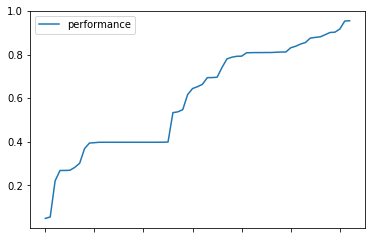

In [82]:
df = df.sort_values(col_name)
ax = df.plot(rot=45, x_compat=True)

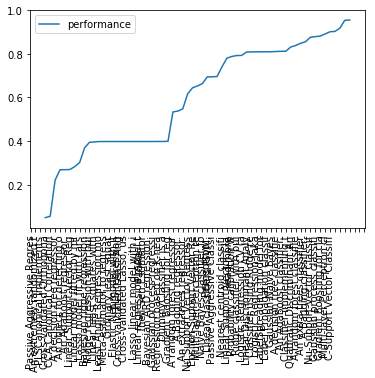

In [83]:
df = df.sort_values(col_name)
ax = df.plot(rot=90, x_compat=True)
ax.xaxis.set_ticklabels(df.index)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

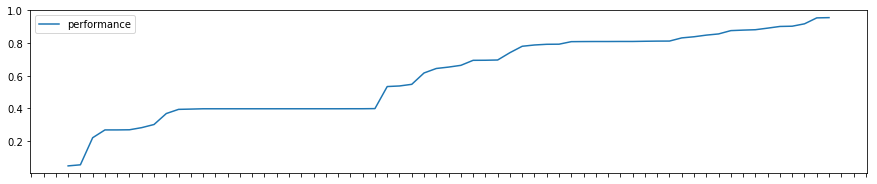

In [84]:
fig , axes = plt.subplots(1,1)
fig.set_size_inches(15,3)
df = df.sort_values(col_name )
axes.xaxis.set_ticklabels(df.index)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
df.plot(rot=45, ax=axes)


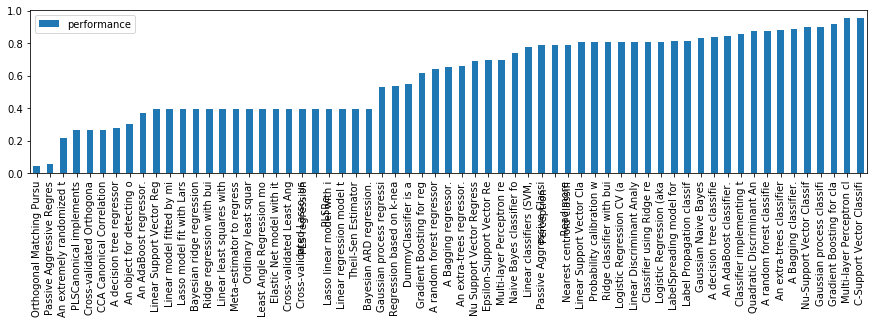

In [85]:
fig , axes = plt.subplots(1,1)
fig.set_size_inches(15,3)
df = df.sort_values(col_name )
axes.xaxis.set_ticklabels(df.index)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
df.plot(kind='bar', rot=90, ax=axes)

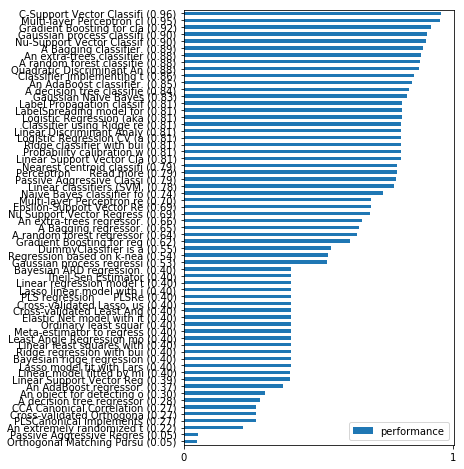

In [86]:
new_labels = []
for i, index in enumerate(df.index):
    new_label = "%s (%.2f)"%(index,df.performance[i])
    new_labels.append(new_label.replace("\n", " "))
    
fig , axes = plt.subplots(1,1)
df.index = new_labels
fig.set_size_inches(15,8)
fig.subplots_adjust(left=0.65)
df.sort_values(col_name).plot(kind='barh', ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

pass

### Which scoring function ?

In [134]:
from sklearn.metrics import precision_recall_curve

In [135]:
from sklearn.metrics import roc_curve

### Tester les métriques sur un algo

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet, BayesianRidge

### L'algo a des performances variables

In [137]:
performances = {}
algorithme = RandomForestClassifier()
for i in range(8):
    modele      = algorithme.fit(X_train, y_train)
    performance = modele.score(   X_test, y_test)
    print(i, performance)
    performances[i] = [performance]

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 0.886969696969697
1 0.8836363636363637
2 0.8851515151515151
3 0.8787878787878788
4 0.8884848484848484
5 0.8781818181818182
6 0.8809090909090909
7 0.8836363636363637


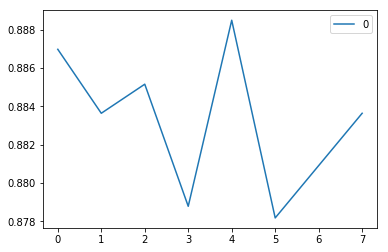

In [138]:
pd.DataFrame.from_dict(performances).T.plot()

### Taux d'erreur sur probabilité d'appartenance à une classe

In [139]:
y_pred = modele.predict_proba(X_test)
for i in y_pred[:30]:
    print(i),

[1. 0.]
[0. 1.]
[0.9 0.1]
[0.9 0.1]
[1. 0.]
[1. 0.]
[0.6 0.4]
[1. 0.]
[0.8 0.2]
[0.7 0.3]
[1. 0.]
[0.9 0.1]
[0.2 0.8]
[0.4 0.6]
[0.5 0.5]
[0.4 0.6]
[1. 0.]
[0.4 0.6]
[1. 0.]
[1. 0.]
[1. 0.]
[0.5 0.5]
[0.3 0.7]
[0.1 0.9]
[0.9 0.1]
[0. 1.]
[1. 0.]
[1. 0.]
[0.1 0.9]
[0.1 0.9]


In [140]:
y_pred[:, 1][:30]

array([0. , 1. , 0.1, 0.1, 0. , 0. , 0.4, 0. , 0.2, 0.3, 0. , 0.1, 0.8,
       0.6, 0.5, 0.6, 0. , 0.6, 0. , 0. , 0. , 0.5, 0.7, 0.9, 0.1, 1. ,
       0. , 0. , 0.9, 0.9])

In [141]:
y_test[:30]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1], dtype=uint8)

### Le taux d'erreur dépend du seuil de choix de basculement vers 1 ou 0

In [142]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [157]:
def bascule(y_pred, seuil):
    return map(lambda prediction : 0 if prediction < seuil   else 1, y_pred)

In [164]:
prediction_selon_seuil = list(bascule(y_pred[:, 1], 0.5))

print(confusion_matrix(prediction_selon_seuil, y_test))
print(prediction_selon_seuil)

[[1877  156]
 [ 233 1034]]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 

In [165]:
def draw_confusion_matrix(y_test, predictions, title):
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score  (y_test, predictions)
    
    plt.matshow  (cm)
    plt.ylabel   ('True Label')
    plt.xlabel   ('Predicted Label')
    plt.suptitle ('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar ()
    plt.show     ()

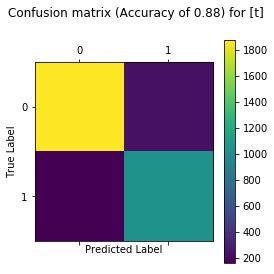

In [166]:
draw_confusion_matrix(y_test, prediction_selon_seuil, "t")

#### Comment tester tous les seuils ? Avec la courbe ROC

In [167]:
taux_de_faux_positif, taux_de_vrai_positifs, seuils =  roc_curve(y_test, y_pred[:, 1])

In [168]:
seuils

array([2. , 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

In [169]:
taux_de_vrai_positifs

array([0.        , 0.13529412, 0.33193277, 0.50840336, 0.65798319,
       0.77142857, 0.86890756, 0.9302521 , 0.9697479 , 0.99243697,
       0.99915966, 1.        ])

In [170]:
taux_de_faux_positif

array([0.00000000e+00, 4.73933649e-04, 2.84360190e-03, 7.58293839e-03,
       2.22748815e-02, 5.30805687e-02, 1.10426540e-01, 1.74407583e-01,
       2.79620853e-01, 4.23222749e-01, 6.35071090e-01, 1.00000000e+00])

In [171]:
auc_global = auc(taux_de_faux_positif, taux_de_vrai_positifs)
auc_global

0.9543247441156557

### Tracer la courbe ROC

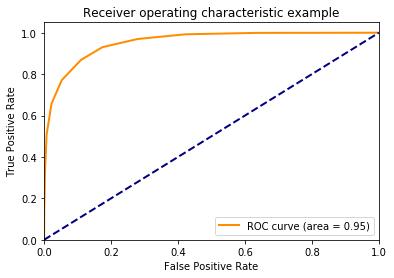

In [172]:
plt.figure()
lw = 2
plt.plot(taux_de_faux_positif, 
         taux_de_vrai_positifs, 
         color='darkorange',
         lw=lw, 
         label='ROC curve (area = %0.2f)' % auc_global)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Optimisation